## Portfolio Optimization Analysis

### Project Goals

This notebook performs portfolio optimization using historical data and tracks its performance through simulated investment and real-time insights.

Key components include:

- Sharpe ratio and mean-variance optimizations
- Risk parity and target-return strategies
- Post-investment simulation of portfolio value and asset-level contributions
- Real-time news integration for each asset in the portfolio

The goal is to combine quantitative modeling with real-world awareness for better portfolio understanding and decision-making.

### Implementation 

1. Import Libraries

In [68]:
import pandas as pd
import numpy as np
import sys
import os
from datetime import datetime
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(""), "..")))
sys.path.append(os.path.abspath("../src"))

from src.data_utils import get_price_data, compute_returns
from src.optimizer import (
    optimize_sharpe,
    minimize_variance,
    target_return_portfolio,
    risk_parity_portfolio,
    efficient_frontier
)
from src.plot_utils import (
    plot_price_trends,
    plot_correlation,
    plot_cumulative_returns,
    plot_weights_bar,
    plot_efficient_frontier
)
from src.simulator import simulate_portfolio, simulate_asset_contributions
from src.news_utils import summarize_news

2. Download & Visualize Data 

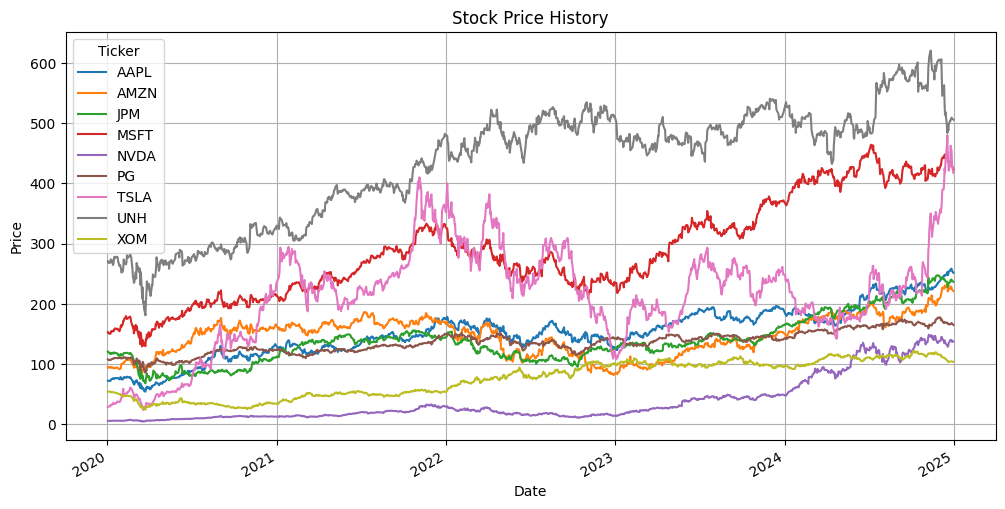

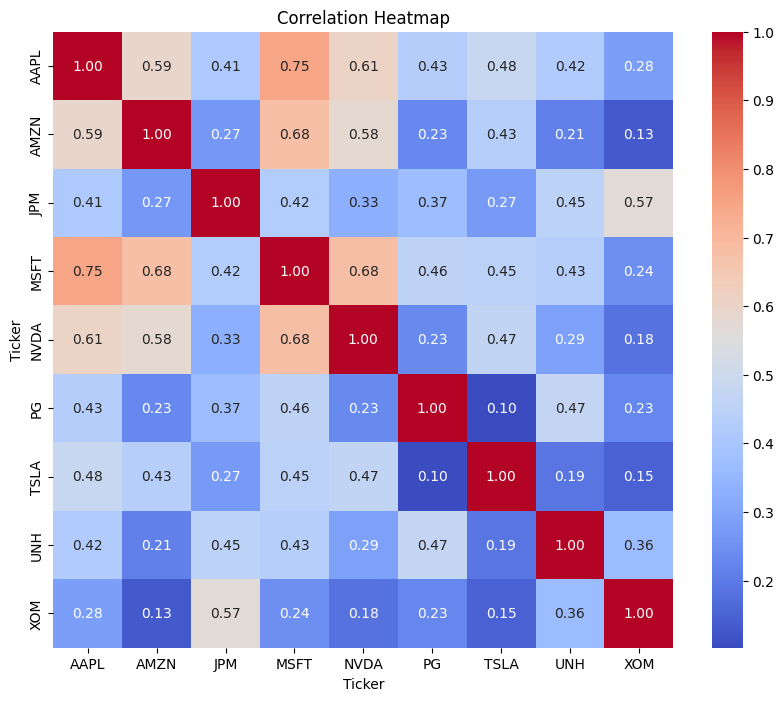

In [24]:
tickers = ['AAPL', 'MSFT', 'AMZN', 'JPM', 'TSLA', 'UNH', 'XOM', 'PG', 'NVDA']
start_date = "2020-01-01"
end_date = "2024-12-31"
investment_date = "2024-12-31"

close_prices = get_price_data(tickers, start=start_date, end=end_date)
returns = compute_returns(close_prices)

# Visualize
plot_price_trends(close_prices)
plot_correlation(returns)

3. Compute Returns & Covariance

In [17]:
mean_returns = returns.mean() * 252 #annualized returns
cov_matrix = returns.cov() * 252

mean_returns.sort_values(ascending=False)

Ticker
NVDA    0.773848
TSLA    0.762471
AAPL    0.299545
MSFT    0.250702
AMZN    0.234575
XOM     0.188009
JPM     0.187753
UNH     0.170294
PG      0.107452
dtype: float64

4. Compute & Compare Portfolio Optimizations 


Max Sharpe Portfolio Weights:
AAPL    0.0000
MSFT    0.0000
AMZN    0.0000
JPM     0.0000
TSLA    0.6181
UNH     0.0000
XOM     0.2535
PG      0.0000
NVDA    0.1284
dtype: float64

Min Variance Portfolio Weights:
AAPL    0.0000
MSFT    0.1447
AMZN    0.0101
JPM     0.0000
TSLA    0.0000
UNH     0.6116
XOM     0.0040
PG      0.0724
NVDA    0.1572
dtype: float64

Target Return Portfolio Weights:
AAPL    0.0000
MSFT    0.1440
AMZN    0.0099
JPM     0.0000
TSLA    0.0000
UNH     0.6059
XOM     0.0094
PG      0.0730
NVDA    0.1578
dtype: float64

Risk Parity Portfolio Weights:
AAPL    0.0977
MSFT    0.1045
AMZN    0.1097
JPM     0.0991
TSLA    0.0657
UNH     0.1995
XOM     0.0616
PG      0.1312
NVDA    0.1312
dtype: float64


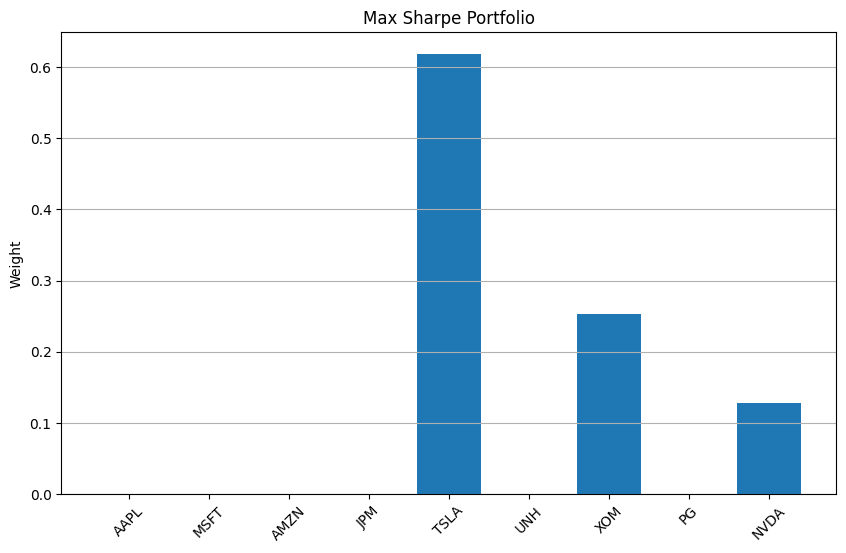

In [25]:
# Max Sharpe
w_sharpe = optimize_sharpe(mean_returns, cov_matrix)

# Min Variance
w_minvar = minimize_variance(cov_matrix)

# Target Return 
w_target = target_return_portfolio(mean_returns, cov_matrix, target_return=0.15)

# Risk Parity
w_risk = risk_parity_portfolio(cov_matrix)

portfolios = {
    "Max Sharpe": w_sharpe,
    "Min Variance": w_minvar,
    "Target Return": w_target,
    "Risk Parity": w_risk    
}

for name, weights in portfolios.items():
    print(f"\n{name} Portfolio Weights:")
    print(pd.Series(weights, index = tickers).round(4))

# Plotting one allocation as an example
plot_weights_bar(w_sharpe, tickers, title = "Max Sharpe Portfolio")

5. Backtest Performance

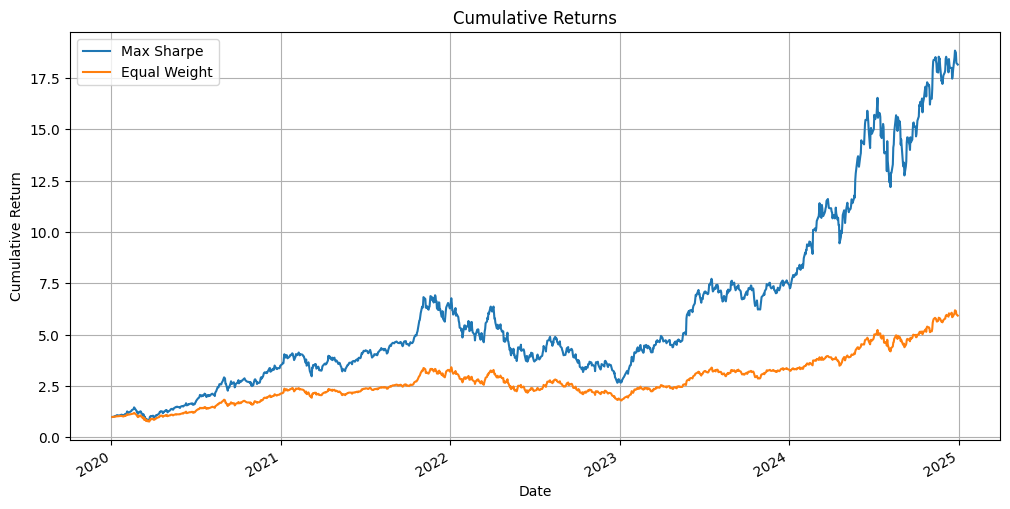

In [26]:
cum_returns = (1 + returns).cumprod()
opt_cum = (cum_returns * w_sharpe).sum(axis = 1)

# benchmark
equal_weights = np.repeat(1 / len(tickers), len(tickers))
equal_cum = (cum_returns * equal_weights).sum(axis = 1)

plot_cumulative_returns({
    "Max Sharpe": opt_cum,
    "Equal Weight": equal_cum
})

6. Plot Efficient Frontier

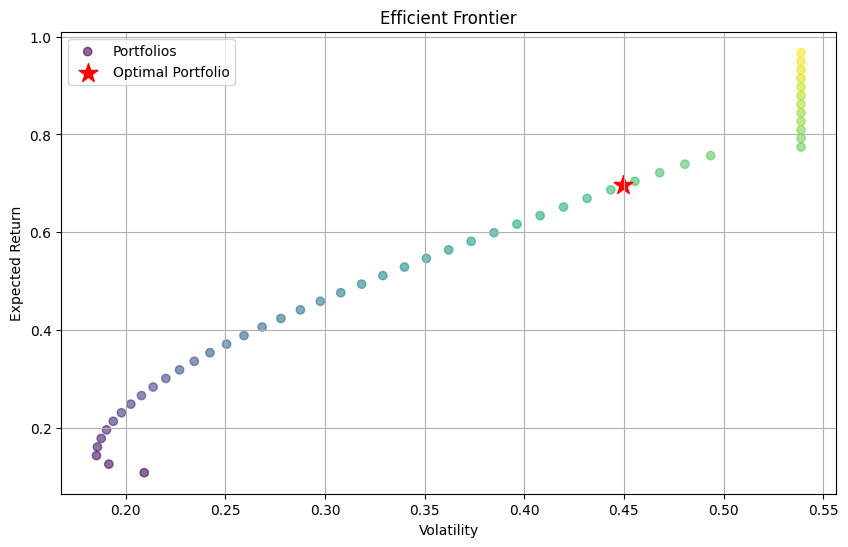

In [27]:
frontier = efficient_frontier(mean_returns, cov_matrix)
vols, rets, _ = zip(*frontier)

opt_ret = np.dot(w_sharpe, mean_returns)
opt_vol = np.sqrt(np.dot(w_sharpe.T, np.dot(cov_matrix, w_sharpe)))

plot_efficient_frontier(vols, rets, optimal = (opt_vol, opt_ret))

7. Simulate Portfolio & Asset Contributions

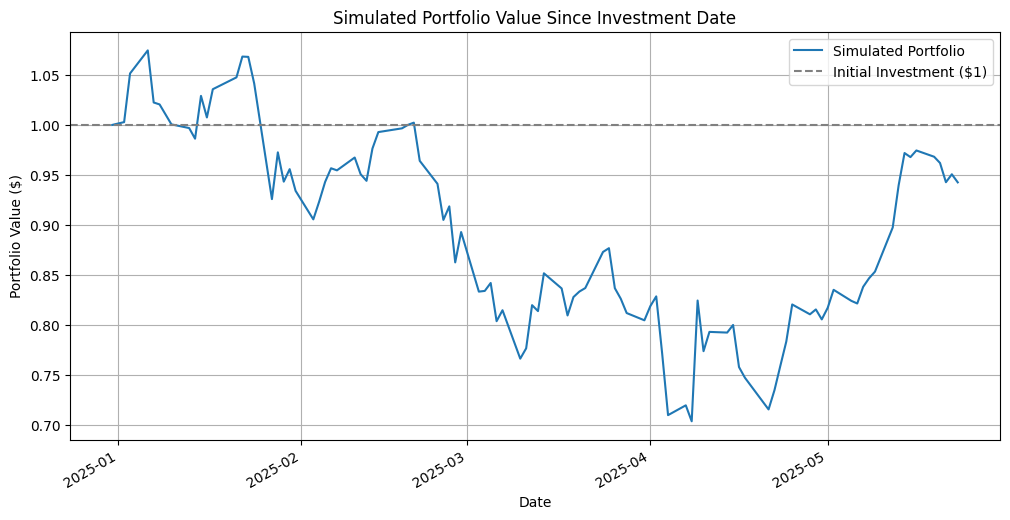

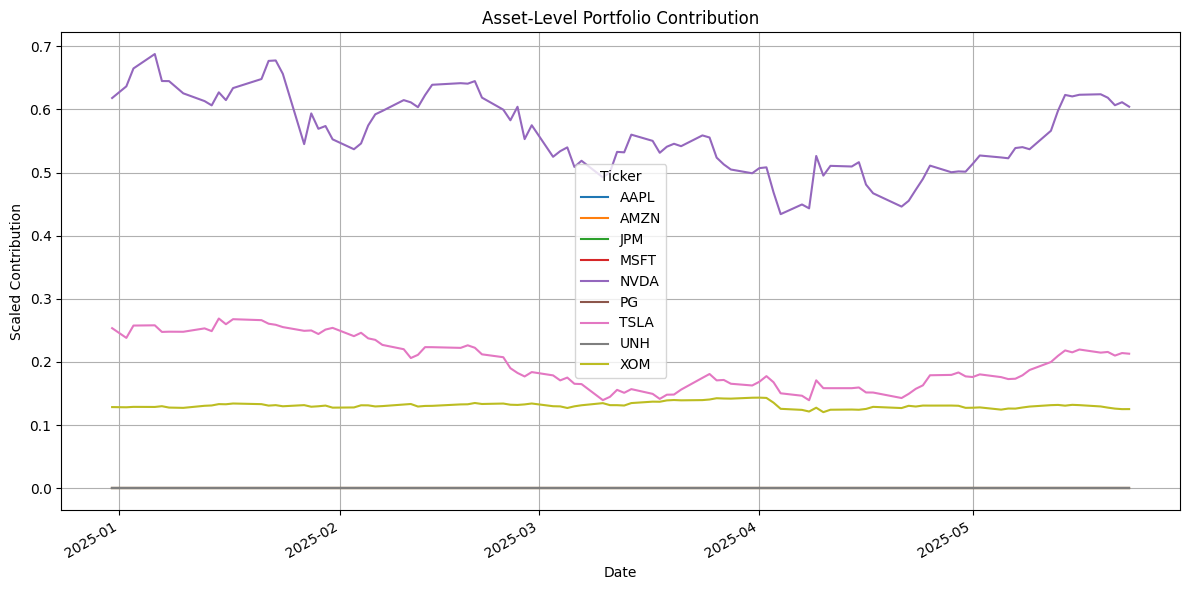

In [28]:
simulated_portfolio = simulate_portfolio(
    tickers = tickers,
    weights = w_sharpe,
    investment_date = investment_date,
    save_path = "../plots/simulated_portfolio.png",
    log_path = "../plots/portfolio_log.csv"
)

simulated_assets = simulate_asset_contributions(
    tickers=tickers,
    weights=w_sharpe,
    investment_date=investment_date,
    save_path="../plots/asset_contributions.png",
    log_path="../plots/asset_contributions.csv"
)

8. Run News Summary

In [70]:
today_str = datetime.today().strftime("%Y-%m-%d")
news_md = summarize_news(
    tickers=tickers,
    limit=3,
    save_path = f"../plots/news_{today_str}.md"
)

### Summary and Observations

- The optimized portfolio allocation based on historical returns and risk shows meaningful improvement over an equal-weight strategy.
- Simulation from the investment date reveals how the strategy performs in real time, accounting for market movements and volatility.
- Live news integration adds context to price behavior, helping explain unexpected moves or trends in specific stocks.
- This modular framework can be extended with rebalancing logic, different risk models, or sentiment-based signals in the future.

This project bridges data science, economics, and real-time market awareness and serves as a powerful base for deeper portfolio analytics.
